In [ ]:
%pip install pennylane

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 48.8 MB/s eta 0:00:00


H = -1 * sum(J[i][j] * sigma[i] * sigma[j])

J[i][j] = nearest neighbour coupling states

In [ ]:
import torch
from torch.autograd import Variable
import pennylane as qml
from pennylane import numpy as np

In [ ]:
dev = qml.device("default.qubit", wires=6)

@qml.qnode(dev, interface="torch")
def circuit(p1, p2, p3, p4, p5):
    qml.Rot(p1[0], p1[1], p1[2], wires=1)
    qml.Rot(p2[0], p2[1], p2[2], wires=2)
    qml.Rot(p3[0], p3[1], p3[2], wires=3)
    qml.Rot(p4[0], p4[1], p4[2], wires=4)
    qml.Rot(p5[0], p5[1], p5[2], wires=5)
    return [qml.expval(qml.PauliZ(i)) for i in range(5)]

In [ ]:
def cost(var1, var2, var3, var4, var5):
    spins = circuit(var1, var2, var3, var4, var5)

    energy = -(1 * spins[0] * spins[1]) - (1 * spins[1] * spins[2]) - (1 * spins[2] * spins[3]) - (1 * spins[3] * spins[4])\
     - (1 * spins[0] * spins[2]) - (1 * spins[0] * spins[3]) - (1 * spins[0] * spins[4]) - (1 * spins[1] * spins[3])\
      - (1 * spins[1] * spins[4]) - (1 * spins[2] * spins[3]) - (1 * spins[2] * spins[4])
    return energy

H=−1(J1s1⊗s2+J2s2⊗s3)  where s1, s2, s3 are the three qubits

In [ ]:
np.random.rand(1,3)[0]

tensor([0.34878512, 0.19450489, 0.99597242], requires_grad=True)

In [ ]:
#testing
test1 = torch.tensor([0, np.pi, 0])
test2 = torch.tensor([0, np.pi, 0])
test3 = np.random.rand(1,3)[0]
test4 = np.random.rand(1,3)[0]
test5 = np.random.rand(1,3)[0]

test2
cost_check = cost(test1, test2, test3, test4, test5)
print("Energy for a random spin config", cost_check)

/usr/local/lib/python3.10/dist-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Energy for a random spin config tensor(2.5846, dtype=torch.float64)


In [ ]:
torch.manual_seed(56)
p1 = Variable((np.pi * torch.rand(3, dtype=torch.float64)), requires_grad=True)
p2 = Variable((np.pi * torch.rand(3, dtype=torch.float64)), requires_grad=True)
p3 = Variable((np.pi * torch.rand(3, dtype=torch.float64)), requires_grad=True)
p4 = Variable((np.pi/43 * torch.rand(3, dtype=torch.float64)), requires_grad=True)
p5 = Variable((np.pi/67 * torch.rand(3, dtype=torch.float64)), requires_grad=True)


var_init = [p1, p2, p3, p4, p5]
cost_init = cost(p1, p2, p3, p4, p5)

print("Randomly initialized angles:")
print(p1)
print(p2)
print(p3)
print(p4)
print(p5)
print("Corresponding cost before optimization:")
print(cost_init)

Randomly initialized angles:
tensor([1.9632, 2.6022, 2.3277], dtype=torch.float64, requires_grad=True)
tensor([0.6521, 2.8474, 2.4300], dtype=torch.float64, requires_grad=True)
tensor([1.8720, 0.7414, 2.2409], dtype=torch.float64, requires_grad=True)
tensor([0.0085, 0.0673, 0.0376], dtype=torch.float64, requires_grad=True)
tensor([0.0224, 0.0019, 0.0081], dtype=torch.float64, requires_grad=True)
Corresponding cost before optimization:
tensor(2.3782, dtype=torch.float64, grad_fn=<SubBackward0>)


In [ ]:
opt = torch.optim.SGD(var_init, lr=0.1)

def closure():
    opt.zero_grad()
    loss = cost(p1, p2, p3, p4, p5)
    loss.backward()
    return loss

var_pt = [var_init]
cost_pt = [cost_init]
x = [0]

for i in range(150):
    opt.step(closure)
    if (i + 1) % 5 == 0:
        x.append(i)
        p1n, p2n, p3n, p4n, p5n = opt.param_groups[0]["params"]
        costn = cost(p1n, p2n, p3n, p4n, p5n)
        var_pt.append([p1n, p2n, p3n, p4n, p5n])
        cost_pt.append(costn)

        print("Energy after step {:5d}: {: .7f} | Angles: {}".format(
            i+1, costn, [p1n.detach().numpy(), p2n.detach().numpy(), p3n.detach().numpy(), p4n.detach().numpy(), p5n.detach().numpy()]),"\n"
        )

Energy after step     5:  0.6044658 | Angles: [array([1.96323939, 1.99700104, 2.32767565]), array([0.65212549, 2.24183822, 2.4299563 ]), array([1.87199129, 0.91139522, 2.24092956]), array([0.00851357, 0.06481105, 0.03761078]), array([0.02241117, 0.00194013, 0.00807991])] 

Energy after step    10: -8.5191267 | Angles: [array([1.96323939, 0.77402313, 2.32767565]), array([0.65212549, 0.6864244 , 2.4299563 ]), array([1.87199129, 0.35931748, 2.24092956]), array([0.00851357, 0.02654839, 0.03761078]), array([0.02241117, 0.00194013, 0.00807991])] 

Energy after step    15: -10.9874808 | Angles: [array([1.96323939, 0.07135118, 2.32767565]), array([0.65212549, 0.02695949, 2.4299563 ]), array([1.87199129, 0.01434511, 2.24092956]), array([0.00851357, 0.00239413, 0.03761078]), array([0.02241117, 0.00194013, 0.00807991])] 

Energy after step    20: -10.9999360 | Angles: [array([1.96323939, 0.00555372, 2.32767565]), array([6.52125492e-01, 8.43333270e-04, 2.42995630e+00]), array([1.87199129e+00, 4.48

Minimum energy = -2, calculated by gradient descent

In [ ]:
p1_final, p2_final, p3_final, p4_final, p5_final = opt.param_groups[0]["params"]
print("Optimized angles:")
print(p1_final)
print(p2_final)
print(p3_final)
print(p4_final)
print(p5_final)

print("Final cost after optimization:")
print(cost(p1_final, p2_final, p3_final, p4_final, p5_final))

Optimized angles:
tensor([1.9632e+00, 8.0214e-32, 2.3277e+00], dtype=torch.float64,
       requires_grad=True)
tensor([6.5213e-01, 6.1959e-43, 2.4300e+00], dtype=torch.float64,
       requires_grad=True)
tensor([1.8720e+00, 3.2969e-43, 2.2409e+00], dtype=torch.float64,
       requires_grad=True)
tensor([8.5136e-03, 2.6909e-33, 3.7611e-02], dtype=torch.float64,
       requires_grad=True)
tensor([0.0224, 0.0019, 0.0081], dtype=torch.float64, requires_grad=True)
Final cost after optimization:
tensor(-11.0000, dtype=torch.float64, grad_fn=<SubBackward0>)


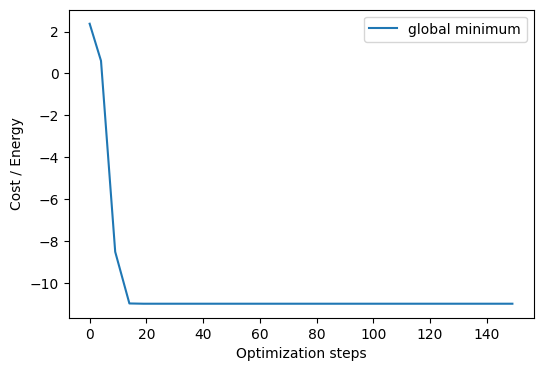

In [ ]:
#plot
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 4))

# Enable processing the Torch trainable tensors
with torch.no_grad():
    plt.plot(x, cost_pt, label = 'global minimum')
    plt.xlabel("Optimization steps")
    plt.ylabel("Cost / Energy")
    plt.legend()
    plt.show()